In [1]:
import os
import pandas as pd
from importlib import reload
import matplotlib
import matplotlib.pyplot as plt
import pickle
import numpy as np
import seaborn as sns
from scipy import stats
from pingouin import welch_anova

/Users/alessandro/CSCvenv/lib/python3.8/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
os.chdir("..")

In [3]:
from my_modules.feature_extraction import one_hot
from my_modules import evaluate_performance
from my_modules.evaluate_performance import mcnemar_test

In [4]:
os.chdir("stability_analysis")

# Load the results

In [5]:
with open("results/y.p", "rb") as fb:
    ytrues = pickle.load(fb)

with open("results/vars_j.p", "rb") as fb:
    varsj = pickle.load(fb) # trained on juveniles/subadults

with open("results/vars_y.p", "rb") as fb:
    varsy = pickle.load(fb) # trained on yearlings

with open("results/vars_a.p", "rb") as fb:
    varsa = pickle.load(fb) # trained on adults

In [6]:
varsa.keys()

dict_keys(['pred', 'probs', 'individuals', 'auc', 'mcc', 'precision', 'recall'])

In [7]:
ytrues.keys()

dict_keys(['y_ja', 'y_jy', 'y_ya', 'id_ja', 'id_ya', 'id_jy'])

In [8]:
idxs_ja = ytrues["id_ja"]
idxs_ya = ytrues["id_ya"]
idxs_jy = ytrues["id_jy"]

In [9]:
n = len(np.unique(ytrues["y_ya"]))
print(f"number of individuals: {n}")

number of individuals: 4


# metrics

In [10]:
metrj, _, _ = evaluate_performance.metrics(
    y=ytrues["y_ya"][idxs_ya], yp=varsj["pred"],
    y_true=one_hot(ytrues["y_ya"][idxs_ya]),
    y_pred=one_hot(varsj["pred"], num_classes=n),
    labels=varsj["individuals"]
)
metrj

Label  Precision  Recall
0     VBBF088   1.000000  0.3500
1     VBBF093   0.523810  0.5500
2     VUKF018   0.485714  0.8500
3     VZUF014   0.823529  0.7000
4  Macro Avg.   0.708263  0.6125

In [11]:
metry, _, _ = evaluate_performance.metrics(
    y=ytrues["y_ja"][idxs_ja], yp=varsy["pred"],
    y_true=one_hot(ytrues["y_ja"][idxs_ja]),
    y_pred=one_hot(varsy["pred"], num_classes=n),
    labels=varsy["individuals"]
)
metry

Label  Precision  Recall
0     VBBF088   0.833333  0.2500
1     VBBF093   0.500000  0.7000
2     VUKF018   0.333333  0.3500
3     VZUF014   0.520000  0.6500
4  Macro Avg.   0.546667  0.4875

In [12]:
metra, _, _ = evaluate_performance.metrics(
    y=ytrues["y_jy"][idxs_jy], yp=varsa["pred"],
    y_true=one_hot(ytrues["y_jy"][idxs_jy]),
    y_pred=one_hot(varsa["pred"], num_classes=n),
    labels=varsa["individuals"]
)
metra

Label  Precision  Recall
0     VBBF088   0.500000   0.100
1     VBBF093   0.485714   0.850
2     VUKF018   0.523810   0.550
3     VZUF014   0.600000   0.600
4  Macro Avg.   0.527381   0.525

# Comparison

In [13]:
df = pd.DataFrame(
    {
        "training": ["juveniles/subadults"] * 40 + \
            ["yearlings"] * 40 + ["adults"] * 40,
        "metric": (["AUC"] * 10 + ["MCC"] * 10 + ["Precision"] * 10 + ["Recall"] * 10) * 3,
        "value": varsj["auc"] + varsj["mcc"] + varsj["precision"] + varsj["recall"] + \
            varsy["auc"] + varsy["mcc"] + varsy["precision"] + varsy["recall"] + \
            varsa["auc"] + varsa["mcc"] + varsa["precision"] + varsa["recall"]
    }
)

df

training  metric     value
0    juveniles/subadults     AUC  0.729167
1    juveniles/subadults     AUC  0.854167
2    juveniles/subadults     AUC  0.854167
3    juveniles/subadults     AUC  0.979167
4    juveniles/subadults     AUC  1.000000
..                   ...     ...       ...
115               adults  Recall  0.625000
116               adults  Recall  0.625000
117               adults  Recall  0.500000
118               adults  Recall  0.375000
119               adults  Recall  0.375000

[120 rows x 3 columns]

In [14]:
18*2.5

45.0

/Users/alessandro/CSCvenv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


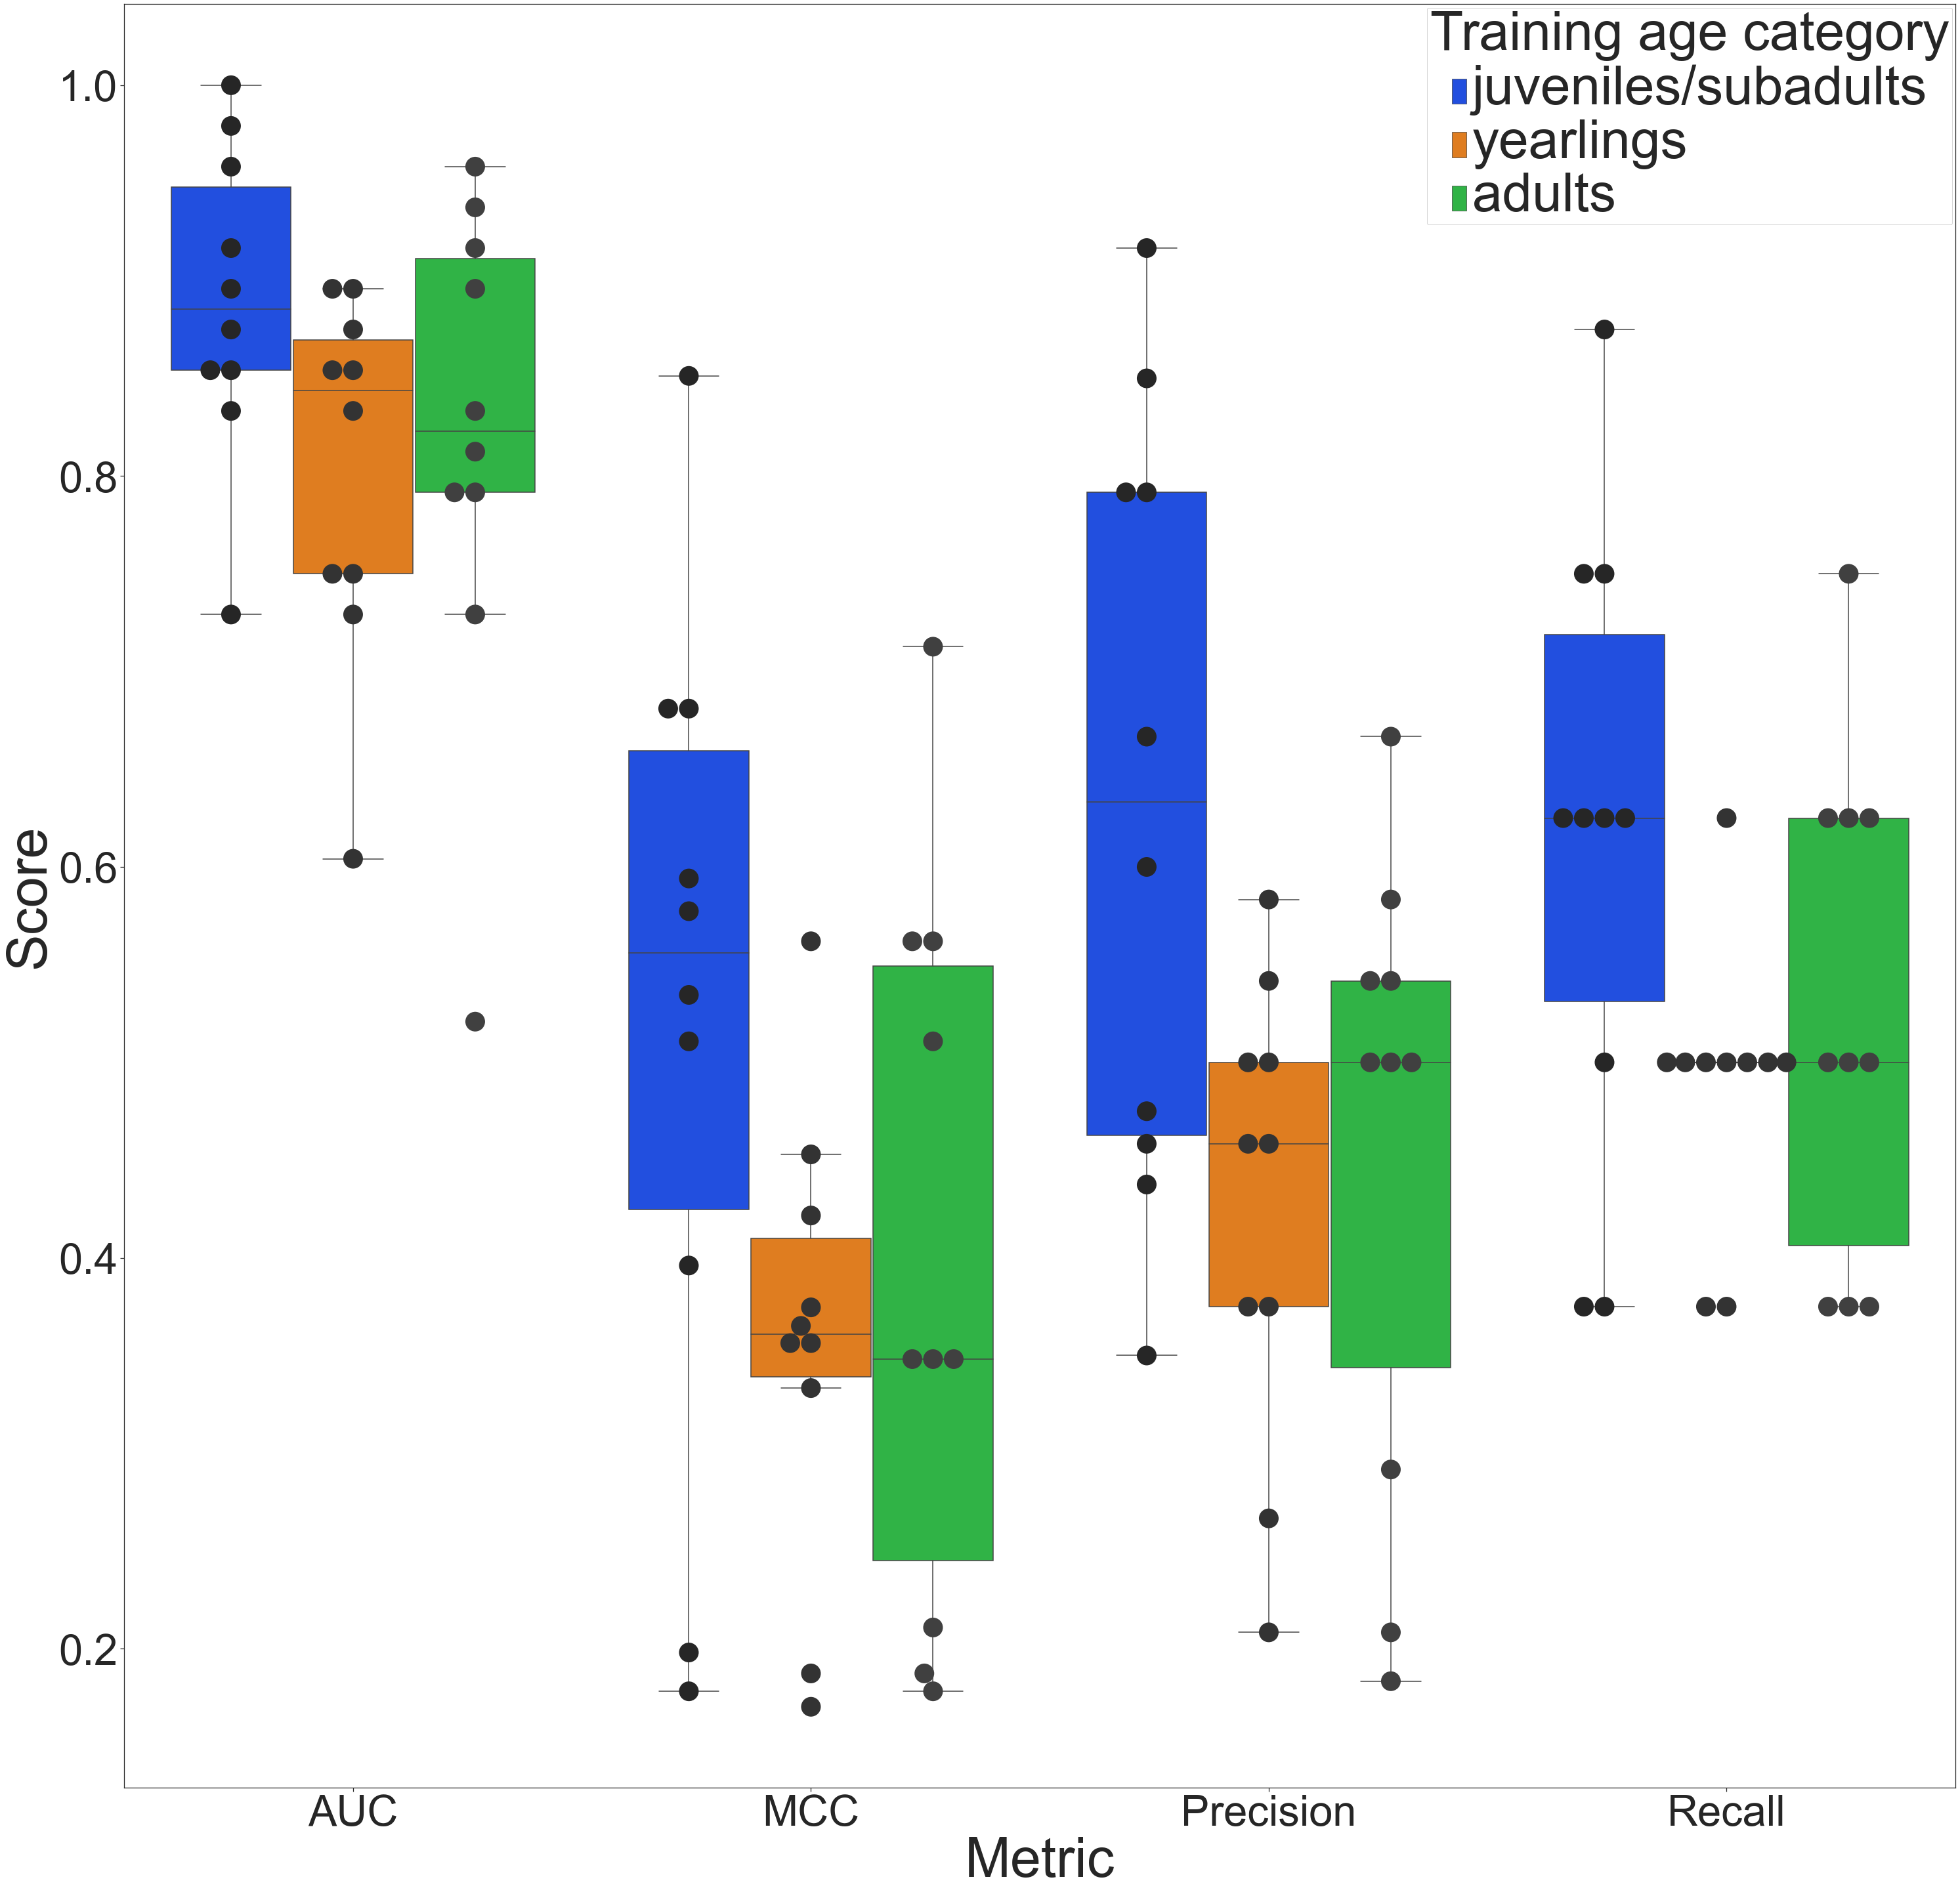

In [20]:
# figure
sns.set(style="ticks")
sns.set_palette("bright")

fig, ax = plt.subplots(1, 1, figsize=(50, 50))

sns.boxplot(
    data=df, x="metric", y="value", hue="training", ax=ax
)
sns.swarmplot(
    data=df, x="metric", y="value", hue="training", ax=ax,
    s=30, color=".25", dodge=True
)

ax.tick_params(axis="both", labelsize=65)
ax.set_xlabel("Metric", fontsize=84)
ax.set_ylabel("Score", fontsize=84)

hands, labs = ax.get_legend_handles_labels()
lgnd = ax.legend(hands[:3], labs[:3])
ax.get_legend().set_title("Training age category")
plt.setp(ax.get_legend().get_title(), fontsize=82)
plt.setp(ax.get_legend().get_texts(), fontsize=82)
for h in lgnd.legendHandles:
    h.set_height(h.get_height()*5)
# ax.get_legend().set_bbox_to_anchor(bbox=(1.03, 0.5))

In [15]:
df.groupby(["metric", "training"]).mean().round(3).to_clipboard()
df.groupby(["metric", "training"]).mean()

value
metric    training                     
AUC       adults               0.818750
          juveniles/subadults  0.889583
          yearlings            0.804167
MCC       adults               0.396813
          juveniles/subadults  0.520224
          yearlings            0.357988
Precision adults               0.451667
          juveniles/subadults  0.633750
          yearlings            0.426667
Recall    adults               0.525000
          juveniles/subadults  0.612500
          yearlings            0.487500

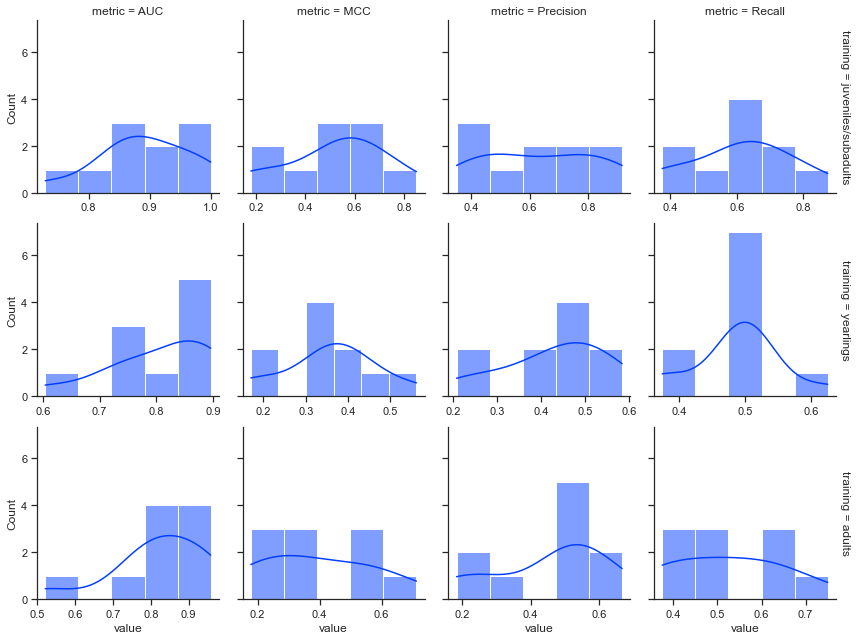

In [16]:
g = sns.FacetGrid(
    data=df, col="metric", row="training", margin_titles=True, sharex=False
)
g.map_dataframe(
    sns.histplot, x="value", kde=True
)

In [17]:
# Welch ANOVA
W_aov = pd.DataFrame(columns=["metric", "Source", "ddof1", "ddof2", "F", "p-unc", "np2"])
for metr in df.metric.unique():

    # for DI testing
    aov = welch_anova(
        data=df.loc[df.metric==metr],
        dv="value", between="training"
        )
    tmp = tmp = pd.DataFrame({
        "metric": [metr]
    })
    tmp = pd.concat([tmp, aov], axis=1)
    W_aov = W_aov.append(tmp)

# W_aov = W_aov.groupby(["metric"]).mean() # not a real mean
W_aov.round(3).to_clipboard()
W_aov

/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/3601579357.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_aov = W_aov.append(tmp)
/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/3601579357.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_aov = W_aov.append(tmp)
/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/3601579357.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_aov = W_aov.append(tmp)
/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/3601579357.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W_aov = W_aov.append(tmp)


metric    Source ddof1      ddof2         F     p-unc       np2
0        AUC  training     2  17.449857  2.609561  0.101976   0.12813
0        MCC  training     2  16.733615  2.163819  0.145949  0.147857
0  Precision  training     2  17.219158  3.964184  0.038359  0.260182
0     Recall  training     2  15.956982  2.494189  0.114142  0.161224

In [18]:
# pairwise Welch t-test
W = pd.DataFrame(
    columns=["test", "metric", "t", "p-value", "DoF", "d"]
)

# test keys
d = {
    "juveniles/subadults vs. yearlings": ["juveniles/subadults", "yearlings"],
    "juveniles/subadults vs. adults": ["juveniles/subadults", "adults"],
    "yearlings vs. adults": ["yearlings", "adults"]
}

i = 0
for k, el in d.items():
    tmp = df.loc[df.training.isin(el)]

    for metr in tmp.metric.unique():
        x = tmp.loc[(tmp.training == el[0]) & (tmp.metric == metr)]["value"]
        y = tmp.loc[(tmp.training == el[1]) & (tmp.metric == metr)]["value"]
        dof = (x.var()/x.size+ y.var()/y.size)**2 / (x.var()**2/((x.size**2)*(x.size-1)) + y.var()**2/((y.size**2)*(y.size-1)))

        t, p = stats.ttest_ind(
            x, y,
            equal_var=False, random_state=42
            )

        # Cohen's d
        dC = (x.mean() - y.mean()) / np.sqrt((x.var() + y.var())/2)

        W = W.append(pd.DataFrame(
            {
            "test": k,
            "metric": metr,
            "t": t,
            "p-value": p,
            "DoF": dof,
            "d": dC
            },
            index=[i]
            )
        )
        i += 1

dd = W.round(3).copy(deep=True)

dd["p-value"].astype(np.str_)

def fun(x):
    if float(x) < 0.001:
        return "<0.001"
    else:
        return str(x)

l = []
for i, p in enumerate(dd["p-value"]):

    l.append(fun(p))

dd["p-value"] = l
dd.to_clipboard()

W

/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/1142156470.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W = W.append(pd.DataFrame(
/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/1142156470.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W = W.append(pd.DataFrame(
/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/1142156470.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W = W.append(pd.DataFrame(
/var/folders/97/dkcpng3131bchrg3gdg5bv840000gp/T/ipykernel_50185/1142156470.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  W = W.append(pd.DataFrame(
/var/folders/97/dkcp

test     metric         t   p-value  \
0   juveniles/subadults vs. yearlings        AUC  2.193284  0.042018   
1   juveniles/subadults vs. yearlings        MCC  2.121147    0.0524   
2   juveniles/subadults vs. yearlings  Precision  2.826658  0.012888   
3   juveniles/subadults vs. yearlings     Recall  2.248595   0.04348   
4      juveniles/subadults vs. adults        AUC  1.484353  0.158323   
5      juveniles/subadults vs. adults        MCC  1.392198    0.1812   
6      juveniles/subadults vs. adults  Precision   2.23474  0.038813   
7      juveniles/subadults vs. adults     Recall  1.341641  0.197163   
8                yearlings vs. adults        AUC  -0.29052  0.775039   
9                yearlings vs. adults        MCC -0.567884  0.578409   
10               yearlings vs. adults  Precision  -0.38848  0.702643   
11               yearlings vs. adults     Recall -0.804984  0.434304   

          DoF         d  
0    17.55105  0.980866  
1   13.886739  0.948606  
2   14.796368   1.26412  
3   12.375488  1.005602  
4   15.074965  0.663823  
5   17.605775   0.62261  
6   17.406566  0.999406  
7   17.195308       0.6  
8     16.4972 -0.129925  
9   15.195674 -0.253965  
10  16.449174 -0.173734  
11  13.982798     -0.36